In [101]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [56]:
# 정규화 함수
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)
    nume = data-np.min(data,0)
    return nume/denom

In [57]:
# 정규화 되돌리기 함수
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back

In [58]:
# 7일간의 5가지 데이터(시가, 종가, 고가, 저가, 거래량)를 받아와서
# 바로 다음 날의 종가를 예측하는 모델로 구성
def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = []
    for i in range(0, len(timeSeries)-seqLength-1):
        tx = timeSeries[i:i+seqLength,:-1]
        ty = timeSeries[i+seqLength+1,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)


In [59]:
def trainingLSTM(trainSet):
    trainX, trainY = buildDataSet(trainSet, seqLength)

    #LSTM 모델 구성
    model = keras.Sequential()
    model.add(layers.LSTM(units=30, activation='tanh', input_shape=[trainX.shape[1], trainX.shape[2]]))
    model.add(layers.Dense(1))
    model.summary()
    # 모델 학습과정 설정
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    stop = EarlyStopping(monitor='loss', patience=15, verbose=1, mode='min')
    save = ModelCheckpoint('my_model.hdf5', save_best_only=True, monitor='loss', mode='min')  


    # 모델 트레이닝
    hist = model.fit(trainX, trainY, epochs=200, batch_size=10,callbacks=[stop, save])

    return model


In [105]:
def useLSTM(model, textX, testY):
    # 7 모델 사용
    xhat = textX
    yhat = model.predict(xhat)
    # print(xhat)
    # print(yhat)
    print("Evaluate : {}".format(np.average((yhat - testY) ** 2)))

    # 원래 값으로 되돌리기
    predict = back_MinMax(xy[trainSize - seqLength:, [-1]], yhat)
    # actual = back_MinMax(open[trainSize-seqLength:, [-1]], testY)
    # print("예측값",predict)
    # print("실제값",actual)

    return int(predict[-1])

In [128]:
df = fdr.DataReader('112040','2010-06-08', '2020-11-17')
del df['Change']
del df['Volume']
# df['5Days']=df['Close'].rolling(5).mean()
# df['10Days']=df['Close'].rolling(10).mean()
# df['20Days']=df['Close'].rolling(20).mean()
# df['60Days']=df['Close'].rolling(60).mean()
# df['120Days']=df['Close'].rolling(120).mean()
df.reset_index(drop=True, inplace=True)
df

,Open,High,Low,Close
0,22150,22925,21800,22925
1,22800,23450,22575,23350
2,23450,23925,23000,23700
3,24000,24099,23500,23750
4,24000,24500,23600,23850
...,...,...,...,...
2573,42400,43550,41750,41950
2574,42200,43450,41500,42000
2575,41800,43100,41450,43100
2576,43700,44750,43300,43900


In [90]:
df1 = pd.read_csv('lg화학 외인기관.csv', header='infer')
df1 = df1[['Date','기관', '외국인']]
df1 = df1[::-1]
print(df1)
df1['Date'] = pd.to_datetime(df1['Date']).apply(lambda x:x.strftime('%Y-%m-%d'))

df1.reset_index(drop=True, inplace=True)

            Date     기관    외국인
2599  2010.06.08   7075  49051
2598  2010.06.09  22141  10123
2597  2010.06.10  14513  21273
2596  2010.06.11 -41918  39453
2595  2010.06.14  -7538  26825
...          ...    ...    ...
4     2020.12.11 -69850  -3734
3     2020.12.14 -81996  -8115
2     2020.12.15  -9640  40399
1     2020.12.16   6440  48187
0     2020.12.17   3488  90494

[2600 rows x 3 columns]


array([[22150, 22925, 21800, 22925],
       [22800, 23450, 22575, 23350],
       [23450, 23925, 23000, 23700],
       ...,
       [41800, 43100, 41450, 43100],
       [43700, 44750, 43300, 43900],
       [44200, 44750, 43650, 44450]], dtype=int64)

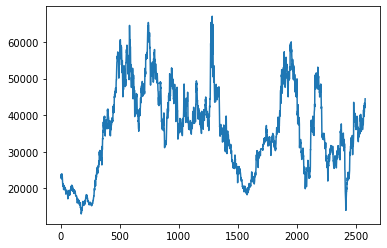

In [129]:
#df2 = pd.concat([df, df1], axis=1)
#df2 = df2.set_index('Date')
#df2 = df2.dropna()
xy = df.to_numpy()
#xy = xy[:,:] # 거래량, 변동률 제거
#xy = xy[::-1] # 역순으로 저장
plt.plot(xy[:,3]) # 전체 종가
xy


In [131]:
#xy = np.c_[xy, xy[:,[3]]]
#print(xy)
# xy = np.delete(xy, 3, axis=1)
# print(xy)
# open = np.c_[xy, xy[:,[0]]]
# open = np.delete(open, 0, axis=1)
# print(open)
# high = np.c_[xy, xy[:,[1]]]
# high = np.delete(high, 1, axis=1)
# print(high)
# low = np.c_[xy, xy[:,[2]]]
# low = np.delete(low, 2, axis=1)
# print(low)
#close = np.c_[xy, xy[:,[3]]]
#close = np.delete(close, 3, axis=1)
print(close)
# vol = np.c_[xy, xy[:,[3]]]
# vol = np.delete(vol, 3, axis=1)
# print(vol)
future = []
future_tmp = []

#xy = np.delete(xy, 3, axis=1)

seqLength = 5 # window size

trainSize = int(len(xy)*0.7)


[[ 390000.  394500.  386000. ...  -14795.   18829.  394500.]
 [ 392000.  395000.  379500. ...  -17860.   -6430.  380500.]
 [ 378000.  386000.  370000. ...   27896.  -30719.  381500.]
 ...
 [ 688000.  710000.  680000. ...  -12175.   82937.  705000.]
 [ 682000.  691000.  675000. ... -110934.  -58907.  677000.]
 [ 678000.  686000.  675000. ...  -33351.   47258.  686000.]]


In [132]:
# trainSetOpen = MinMaxScaler(open[0:trainSize])
# testSetOpen = MinMaxScaler(open[trainSize-seqLength:])

# trainSetHigh = MinMaxScaler(high[0:trainSize])
# testSetHigh = MinMaxScaler(high[trainSize-seqLength:])

# trainSetLow = MinMaxScaler(low[0:trainSize])
# testSetLow = MinMaxScaler(low[trainSize-seqLength:])

trainSetClose = MinMaxScaler(xy[0:trainSize])
testSetClose = MinMaxScaler(xy[trainSize-seqLength:])

In [133]:
# modelOpen = trainingLSTM(trainSetOpen)
# modelHigh = trainingLSTM(trainSetHigh)
# modelLow = trainingLSTM(trainSetLow)
modelClose = trainingLSTM(trainSetClose)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30)                4080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
180/180 [==============================] - 0s 2ms/step - loss: 0.0113 - mae: 0.0742
Epoch 2/200
180/180 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0399
Epoch 3/200
180/180 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0404
Epoch 4/200
180/180 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0393
Epoch 5/200
180/180 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0389
Epoch 6/200
180/180 [============

In [134]:
# testOpenX, testOpenY = buildDataSet(testSetOpen, seqLength)
# testHighX, testHighY = buildDataSet(testSetHigh, seqLength)
# testLowX, testLowY = buildDataSet(testSetLow, seqLength)
testCloseX, testCloseY = buildDataSet(testSetClose, seqLength)
#testVolX, testVolY = buildDataSet(testSetVol, seqLength)

In [135]:
# nextOpen = useLSTM(modelOpen, testOpenX, testOpenY)
# nextHigh = useLSTM(modelHigh, testHighX, testHighY)
# nextLow = useLSTM(modelLow, testLowX, testLowY)
nextClose = useLSTM(modelClose, testCloseX, testCloseY)
#nextVol = useLSTM(modelVol, testVolX, testVolY)
# future_tmp.append(nextOpen)
# future_tmp.append(nextHigh)
# future_tmp.append(nextLow)
future_tmp.append(nextClose)
#future_tmp.append(nextVol)

print(future_tmp)


Evaluate : 0.019842495269267953
[37897]
